# **Datathon Cajamar UniversityHack 2021**

The competition consists of performing a data analysis and feature extraction in order to obtain a model capable of **estimating sales for each product and date.**

The **data** we work with is provided by the Spanish company PcComponentes that sells technological products.

This notebook is the final work done and summarized in the most important parts.

---


## **Evaluation**

Projects are evaluated following two rules:


1.   The quality of the code, the analytical techniques used and the description of the project presented.
2. Error metric between real values and stock outs (this is, when predicted sales are lower than real demand.

This is  the metric to minimize:
(0.7 * rRMSE) + (0.3 * (1 - CF)),
- CF is the % of favorable cases, defined as those in which there has been no lack of stock, that is, the demand has been equal or less than forecasts.
- rRMSE is defined as 

>![](https://www.cajamardatalab.com/datathon-cajamar-universityhack-2021/retos/predictivo/formula.jpg)

Being:
* "n": number of cases
* "Y<sub>i</sub>": real value
* "Ŷ<sub>i</sub>": estimated value
* "Ӯ": mean of the real values

## **Authors**

1. **Anton Chernysh**: anton_chernysh@outlook.es &  https://github.com/Visn0
2. **Arismendi Sánchez, Carlos Eduardo**: carlos.arismendisanchez@gmail.com & https://github.com/carlosarismendi






#0.Imports


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from datetime import date
import holidays
import pickle
import seaborn as sns
import math
import time

import sklearn
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, QuantileTransformer, Normalizer, RobustScaler, Normalizer
from scipy.stats import zscore
from sklearn.ensemble import VotingRegressor, GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, BatchNormalization, Flatten, LSTM, Activation, Input, GRU, LeakyReLU,  ReLU
from tensorflow.keras.initializers import he_uniform
from tensorflow.keras.regularizers import L1, L2

from tensorflow.keras import backend as K
from tensorflow.python.framework import ops
from tensorflow.python.ops import math_ops

from os.path import join
from google.colab import drive
drive.mount('/content/drive')

print(f'tensorflow version: {tf.__version__}')
print(f'sklearn version: {sklearn.__version__}')

tf.random.set_seed(0)

Mounted at /content/drive
tensorflow version: 2.6.0
sklearn version: 0.22.2.post1


#1.Constants

In [ ]:
DIR_DRIVE_BASE      = '/content/drive/My Drive'
DIR_COMPETICIONES   = join( DIR_DRIVE_BASE, 'UniversityHack')
DIR_DATASET_BASE    = join( DIR_COMPETICIONES, 'dataset')
DIR_LEARNING_CURVES = join( DIR_COMPETICIONES, 'learning_curves')
DIR_SCORES          = join( DIR_COMPETICIONES, 'scores')
DIR_CHECKPOINTS     = join( DIR_COMPETICIONES, 'checkpoints')
DIR_LOGS            = join( DIR_COMPETICIONES, 'logs')

LABEL_LSTM         = 'lstm'
LABEL_CONVOLUTION  = 'convolution'
LABEL_ALL_ITEM_ROW = 'all_item_row'
LABEL_ONE_ITEM_ROW = 'one_item_row'

# 2.Definitions

## 2.1. Preprocess

### 2.1.1. Import

In [ ]:
def import_data(file, submission):
  """
  file: url to the file.
  submission: boolean indicating whether to import file to predict or to model.
  """
  drive.mount('/content/drive')

  # Read file
  df = pd.read_csv(file, sep='|', header=0, decimal=',')  
  df.drop_duplicates(inplace=True, keep='first', ignore_index=True)

  # Transform date format to datetime
  if submission:  
    df['fecha'] = pd.to_datetime(df['fecha'], format='%Y/%m/%d')
  else:
    df['fecha'] = pd.to_datetime(df['fecha'], format='%d/%m/%Y %H:%M:%S')
  
  # Extract day, month and year
  df['day']   = df['fecha'].dt.day.astype('float64', errors='ignore')
  df['month'] = df['fecha'].dt.month.astype('float64', errors='ignore')
  df['year']  = df['fecha'].dt.year.astype('float64', errors='ignore')  
  
  # Transform date into sine and cosine waves
  df = parse_date_to_sin_cos(df)
  # Get timestamp from date
  df['timestamp'] = df['fecha'].map(datetime.datetime.timestamp)

  # OneHotEncoder
  df.loc[df['estado'] == 'Rotura', 'estado']    = 1.0
  df.loc[df['estado'] == 'Transito', 'estado']  = 2.0
  df.loc[df['estado'] == 'No Rotura', 'estado'] = 3.0

  # Extract holidays in Spain (main clients)
  sp_holidays    = holidays.Spain(expand=True, observed=True)
  df['fiestaSP'] = df['fecha'].map(lambda x: x in sp_holidays).astype(int)

  # Extract holidays in Portugal (second main clients)
  pt_holidays      = holidays.Portugal(expand=True, observed=True)
  df['fiestaPT']   = df['fecha'].map(lambda x: x in pt_holidays).astype(int)  
  
  # Another custom OneHotEncoder
  df['categoria_uno'] = df['categoria_uno'].map(ord)

  # This data can have null values (represented with '-')
  # We replace them with nulls to be able to work with them later
  df['categoria_dos'] = df['categoria_dos'].apply(lambda x: np.nan if x == "-" else float(x))
  df['antiguedad']    = df['antiguedad'].apply(lambda x: np.nan if x == "-" else float(x))

  df = df.astype({ "id": float, "categoria_uno": float, "categoria_dos": float , "antiguedad": float , "precio": float, "estado": float, "visitas": float, "dia_atipico": float, "campaña": float })
  if not submission:
    df = df.astype({ "unidades_vendidas": float })

  return df 

### 2.1.2.  Sin/Cos extraction from date

In [ ]:
def parse_date_to_sin_cos(df):
  day = 24.0 * 60.0* 60.0
  week = 7 * day
  year = 365.2425 * day

  timestamp_s = df['fecha'].map(datetime.datetime.timestamp)
  df['Year sin'] = np.sin(timestamp_s * (2.0 * np.pi / year))
  df['Week sin'] = np.sin(timestamp_s * (2.0 * np.pi / week))
  df['Year cos'] = np.cos(timestamp_s * (2.0 * np.pi / year))
  df['Week cos'] = np.cos(timestamp_s * (2.0 * np.pi / week))  

  return df

### 2.1.3. Custom Null values fill


In [ ]:
def fill_nan(df_nan, pad_columns, backfill_columns):
  """
    df_nan: dataframe to work with
    pad_columns: list of columns to fill with pad method
    backfill_columns: list of columns to fill with backfill method    
  """
  df = df_nan.copy()
  df.sort_values(['fecha'], axis=0, inplace=True)

  unicos = df['id'].unique()
  df_filled = pd.DataFrame(columns=df.columns)
  for id in unicos:
    df_ids_cols = df[df['id'] == id].copy()
    df_ids_cols[pad_columns]      = df_ids_cols[pad_columns].interpolate(method='pad', inplace=False)
    df_ids_cols[backfill_columns] = df_ids_cols[backfill_columns].interpolate(method='backfill', inplace=False)  
    df_filled = pd.concat([df_filled, df_ids_cols])
  
  df_filled = df_filled.dropna(subset=['precio'])

  df_filled.sort_values(['id','fecha'], axis=0, inplace=True)
  df_filled['antiguedad'].interpolate(method='pad', inplace=True)
  df_filled['antiguedad'].interpolate(method='backfill', inplace=True)

  df_filled.sort_values(['id', 'precio'], axis=0, inplace=True)
  df_filled['categoria_dos'].interpolate(method='pad', inplace=True)
  df_filled['categoria_dos'].interpolate(method='backfill', inplace=True)

  df_filled.sort_values(['fecha', 'id'], axis=0, inplace=True)
  return df_filled


### 2.1.4. Age preprocess

In [ ]:
def antiguedad_estimate_apply(row, fecha_max, antiguedad_max, categoria_max):
  date_diff = row['fecha'] - fecha_max
  row['antiguedad'] = date_diff.days + antiguedad_max
  row['categoria_dos'] = categoria_max
  return row

def antiguedad_estimate(df_model, df_estimate):
  df_final = pd.DataFrame(columns=df_estimate.columns)
  estimate_ids = df_estimate['id'].unique()

  for id in estimate_ids:
    df_id_estimate = df_estimate[df_estimate['id'] == id].copy()
    df_id_model = df_model[df_model['id'] == id].copy()
    
    fecha_max = df_id_model['fecha'].max()
    antiguedad_max = df_id_model['antiguedad'].max()
    categoria_max = df_id_model['categoria_dos'].max()
    
    df_id_estimate = df_id_estimate.apply(antiguedad_estimate_apply, args=(fecha_max, antiguedad_max, categoria_max), axis=1)
    df_final = pd.concat([df_final, df_id_estimate])

  df_final.sort_values(['id', 'fecha'], inplace=True, axis=0, ignore_index=True)
  return df_final


def antiguedad_model(df_model):
  df_final = pd.DataFrame(columns=df_model.columns)
  model_ids = df_model['id'].unique()

  for id in model_ids:
    df_id_model = df_model[df_model['id'] == id].copy()
    
    fechamin = df_id_model['fecha'].min()
    df_id_model['date_diff'] = (df_id_model['fecha'] - fechamin).map(lambda x: x.days)
    df_id_model['antiguedad'] = df_id_model['antiguedad'] + df_id_model['date_diff']
    df_id_model.drop(['date_diff'], axis=1, inplace=True)
        
    df_final = pd.concat([df_final, df_id_model])

  df_final.sort_values(['id', 'fecha'], inplace=True, axis=0, ignore_index=True)
  return df_final

### 2.1.5. Drop duplicates

In [ ]:
def drop_duplicates(df_raw):
  df = df_raw.copy()

  df.drop_duplicates(subset=['id', 'fecha'], keep='last', inplace=True, ignore_index=True)  
  df.sort_values(['fecha','id'], axis=0, inplace=True, ignore_index=True)  

  print("DF raw: \t", df_raw.shape)
  print("DF dups clean: \t", df.shape)
  
  return df

### 2.1.6. Scale data

In [ ]:
def scale(df, cols_to_scale, scaler, fit=False, append_scaled=False):
  df_copy = df.copy()

  if len(cols_to_scale) == 0:
    return df_copy
  
  # Save not scaled columns
  cols_not_scaled = [col for col in df_copy.columns if col not in cols_to_scale] 
  
  # Fit scaler
  if fit:    
    scaler = scaler.fit(df_copy[cols_to_scale])
    print(f'Fit: {fit}')

  # Transform dataset
  scaled = scaler.transform(df_copy[cols_to_scale])
  scaled = pd.DataFrame(data=scaled, index=df_copy.index, columns=cols_to_scale)

  if append_scaled:
    scaled = df_copy.join(scaled, rsuffix='_scaled')
  else:    
    scaled = scaled.join(df_copy[cols_not_scaled])  
    
  return scaler, scaled

#### 2.1.6.1. Todos los items en una fila

In [ ]:
def reordenar_dataframe(df, train=False):
  unique_ids   = len(df['id'].unique())
  unique_dates = len(df['fecha'].unique())

  df.sort_values(['id','fecha'], axis=0, inplace=True, ignore_index=True)
  df_reorden = []
  i = 1
  if train:
    while i <= unique_ids :
      df_reorden.append(df[(i-1)*unique_dates : (i-1)*unique_dates + unique_dates])
      i = i + 1
  
  columns_important = ['visitas','precio','campaña'] #id ,'antiguedad''estado','categoria_dos','dia_atipico','categoria_uno',
  df_final_X = df_reorden[0][columns_important + ['unidades_vendidas','Year sin','Week sin']] #'day','month','year',

  if train: 
    df_final_X.drop('unidades_vendidas', axis=1, inplace=True)
    df_final_X.reset_index(drop=True, inplace=True)
    df_final_y = df_reorden[0][['unidades_vendidas']]
    df_final_y.reset_index(drop=True, inplace=True)

  for i in range(1, len(df_reorden), 1):
    df_copy = df_reorden[i].copy()
    df_copy.reset_index(drop=True, inplace=True)

    for c in columns_important:
      df_final_X[f'{c}_{i}'] = df_copy[f'{c}']    

    if train:
      df_final_y[f'unidades_vendidas{i}'] = df_copy['unidades_vendidas']

  print(f"Reorden shape: {df_final_X.shape}")
  display(df_final_X)
  if train: 
    return df_final_X, df_final_y
  
  return df_final_X, None

### 2.1.7. Data format 

#### 2.1.7.1. Item and date per row

In [ ]:
def individual_item_per_row(df):
  df.sort_values(['fecha', 'id'], axis=0, inplace=True, ignore_index=True)
  X = df.drop(labels=['unidades_vendidas', 'fecha', 'timestamp'], axis=1)
  y = pd.DataFrame(df.pop('unidades_vendidas').values, columns=['unidades_vendidas'])
  return X, y

#### 2.1.7.2. LSTM: all ids in the same row
The intention was to create a general LSTM model that would unify the information of all the products and be ordered by date. This model was not adequate for this case, since we did not have data for all dates, and the delivery of our predictions was over a long period of dates, so our models would be accumulating the error for later dates.

In [ ]:
def parse_for_lstm(X, y, train=False, look_back_size=1, past_size=3):    
  X_copy = X.copy()
  if {'timestamp', 'fecha'}.issubset(X.columns):
    X_copy = X_copy.drop(['timestamp','fecha'], axis=1)

  X_final = X_copy.copy()
  for i in range(past_size):
    X_shifted = X_copy[X_copy.columns].shift( -(look_back_size+i) )
    cols = []
    for c in X_copy.columns:
      cols.append(f'{c}_{i-1}_{i}')

    X_shifted.columns = cols

    X_final = X_final.join(X_shifted)
    X_final = X_final.dropna()
  
  if train:
    y = y[look_back_size+past_size-1:]
  
  X_final = np.reshape( X_final.to_numpy(), (len(X_final), past_size+1, int(X_final.shape[-1]/(past_size+1))) )
  return X_final, y

#### 2.1.7.X. Format data selector

In [ ]:
def split_xy(df_raw, kind=1, train=False, cols_to_scale=None):
  X = None
  y = None  
  kind_label = None
  df_copy = df_raw.copy()          

  # deprecated
  # if kind == 1:
  #   X, y = reordenar_dataframe(df_copy, train=train)
  #   kind_label = 'all_item_row'
  # elif kind == 2:
  #   X, y = parse_data_for_convolutions(df_copy, train)
  #   kind_label = 'convolutions'
  if kind == 3:
    if train:
      X, y = individual_item_per_row(df_copy)
    else:
      X = df_copy
    kind_label = 'one_item_row'
  elif kind == 4:
    X, y = reordenar_dataframe(df_copy, train=train)        
    X, y = parse_for_lstm(X, y, train, past_size=30)
    kind_label = 'lstm'
  
  return  X, y

## 2.2. Plots

### 2.2.1. Correlation

In [ ]:
def correlation(df):
  corr_mat = df.corr()

  fig, ax = plt.subplots(1, 1, figsize=(15, 10))
  sns.heatmap(corr_mat, vmin=-1.0, vmax=1.0, cmap="jet")
  ax.set_title('Correlation map', fontsize=23)
  plt.show()

### 2.2.2. Generic (lines)

In [ ]:
def plots(X, y, label, ax=None, fig=None):
  if len(X) != len(y):
    raise Exception('len(X) != len(y)')

  n_plots = len(y)
  
  if ax is None or fig is None:
    fig = plt.figure(figsize=(int(25), int(5)))
    ax1 = fig.add_subplot(2, 1, 1)
  else:
    ax1 = fig.add_subplot(2, 1, 2, sharex=ax)

  for i in range(0, n_plots, 1):
    name = label[i]

    ax1.plot(X[i], y[i], label=name) # x, y
    ax1.set_title(f'Plot: {i}, {name}')

    plt.subplots_adjust(top=0.97, bottom=0.03, left=0.03, right=0.97, hspace=0.1, wspace=0.15)

  plt.legend()
  plt.grid()
  plt.plot()
  return fig, ax1

## 2.3. ZScore

In [ ]:
class ZScore:  
  def __init__(self):
    self.variance           = None
    self.standard_deviation = None
    self.fitted_cols        = None
  
  def is_fit(self):
    if self.variance is None or self.standard_deviation is None:
      raise Exception('ZScore is not fitted.')

  def check_columns(self, df):
    for col in self.fitted_cols:
      if col not in df.columns:
        raise Exception(f'Column: {col} not found in Dataframe.')

  def fit(self, df, axis=0):
    """
      axis: default 1 (columns).
    """
    self.variance           = df.var(axis=axis)
    self.standard_deviation = df.std(axis=axis)
    self.fitted_cols        = df.columns    
    return self

  def transform(self, df):
    self.is_fit()
    self.check_columns(df)
    return (df - self.variance) / self.standard_deviation

  def inverse_transform(self, df_zscores):
    self.is_fit()
    self.check_columns(df_zscores)
    return df_zscores * self.standard_deviation + self.variance



## 2.4. Save and load pickle files

In [ ]:
def save_pickle(dir, filename, data):  
  pickle_out = open( join(dir, f'{filename}.pckl'), 'wb')
  pickle.dump(data, pickle_out)
  pickle_out.close()

def load_pickle(dir, filename):  
  pickle_in = open( join(dir, f'{filename}.pckl'), 'rb' )
  data = pickle.load(pickle_in)
  pickle_in.close()
  return data

# 3. Preprocess pipeline

## 3.1. Import and basic preprocess

In [ ]:
model_route    = join( DIR_DATASET_BASE, 'raw', 'Modelar_UH2021.txt' )
estimate_route = join( DIR_DATASET_BASE, 'raw', 'Estimar2.txt' )

df_model_raw    = import_data(model_route, submission=False)
df_estimate_raw = import_data(estimate_route, submission=True)

MODEL_IDS      = df_model_raw['id'].unique() #4168
MODEL_DATES    = df_model_raw['fecha'].unique() # 487
ESTIMATE_IDS   = df_estimate_raw['id'].unique() #2736
ESTIMATE_DATES = df_estimate_raw['fecha'].unique() #2736

df_model_raw.sort_values(['fecha', 'id'], inplace=True, ignore_index=True)
display(df_model_raw.shape)
display(df_estimate_raw.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


(2040037, 21)

(212841, 20)

### Dataset

In [ ]:
display(df_model_raw)
display(df_estimate_raw)

,fecha,id,visitas,categoria_uno,categoria_dos,estado,precio,dia_atipico,campaña,antiguedad,unidades_vendidas,day,month,year,Year sin,Week sin,Year cos,Week cos,timestamp,fiestaSP,fiestaPT
0,2015-06-01,21972.0,0.0,67.0,75.0,3.0,NaN,0.0,0.0,5241.0,0.0,1.0,6.0,2015.0,0.516251,-0.433884,-0.856437,-0.900969,1.433117e+09,0,0
1,2015-06-01,23910.0,5.0,67.0,170.0,3.0,6.07,0.0,0.0,5241.0,3.0,1.0,6.0,2015.0,0.516251,-0.433884,-0.856437,-0.900969,1.433117e+09,0,0
2,2015-06-01,24306.0,13.0,65.0,46.0,3.0,NaN,0.0,0.0,NaN,0.0,1.0,6.0,2015.0,0.516251,-0.433884,-0.856437,-0.900969,1.433117e+09,0,0
3,2015-06-01,27144.0,15.0,69.0,230.0,3.0,NaN,0.0,0.0,4064.0,0.0,1.0,6.0,2015.0,0.516251,-0.433884,-0.856437,-0.900969,1.433117e+09,0,0
4,2015-06-01,27504.0,7.0,67.0,157.0,3.0,NaN,0.0,0.0,5261.0,0.0,1.0,6.0,2015.0,0.516251,-0.433884,-0.856437,-0.900969,1.433117e+09,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2040032,2016-09-30,456982.0,6575.0,70.0,336.0,3.0,81.28,0.0,0.0,NaN,30.0,30.0,9.0,2016.0,-0.999825,0.781831,-0.018696,0.623490,1.475194e+09,0,0
2040033,2016-09-30,457416.0,1395.0,70.0,336.0,3.0,50.38,0.0,0.0,130.0,9.0,30.0,9.0,2016.0,-0.999825,0.781831,-0.018696,0.623490,1.475194e+09,0,0
2040034,2016-09-30,457422.0,1080.0,70.0,336.0,1.0,NaN,0.0,0.0,130.0,0.0,30.0,9.0,2016.0,-0.999825,0.781831,-0.018696,0.623490,1.475194e+09,0,0
2040035,2016-09-30,458650.0,1385.0,75.0,340.0,3.0,NaN,0.0,0.0,126.0,0.0,30.0,9.0,2016.0,-0.999825,0.781831,-0.018696,0.623490,1.475194e+09,0,0


,fecha,id,visitas,categoria_uno,categoria_dos,estado,precio,dia_atipico,campaña,antiguedad,day,month,year,Year sin,Week sin,Year cos,Week cos,timestamp,fiestaSP,fiestaPT
0,2016-10-01,21972.0,5.0,67.0,75.0,3.0,5.84,0.0,0.0,5150.0,1.0,10.0,2016.0,-0.999999,9.749279e-01,-0.001494,-0.222521,1.475280e+09,0,0
1,2016-10-02,21972.0,15.0,67.0,75.0,3.0,5.84,0.0,0.0,5150.0,2.0,10.0,2016.0,-0.999877,4.338837e-01,0.015708,-0.900969,1.475366e+09,0,0
2,2016-10-03,21972.0,5.0,67.0,75.0,3.0,5.84,0.0,0.0,5150.0,3.0,10.0,2016.0,-0.999458,-4.338837e-01,0.032905,-0.900969,1.475453e+09,0,0
3,2016-10-04,21972.0,5.0,67.0,75.0,3.0,5.84,0.0,0.0,5150.0,4.0,10.0,2016.0,-0.998745,-9.749279e-01,0.050093,-0.222521,1.475539e+09,0,0
4,2016-10-05,21972.0,0.0,67.0,75.0,3.0,5.84,0.0,0.0,5150.0,5.0,10.0,2016.0,-0.997735,-7.818315e-01,0.067266,0.623490,1.475626e+09,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212836,2016-12-26,458660.0,1085.0,75.0,340.0,3.0,70.85,1.0,0.0,35.0,26.0,12.0,2016.0,-0.092719,-4.338837e-01,0.995692,-0.900969,1.482710e+09,1,0
212837,2016-12-27,458660.0,965.0,75.0,340.0,3.0,70.85,1.0,0.0,35.0,27.0,12.0,2016.0,-0.075577,-9.749279e-01,0.997140,-0.222521,1.482797e+09,0,0
212838,2016-12-28,458660.0,1005.0,75.0,340.0,3.0,70.85,1.0,0.0,35.0,28.0,12.0,2016.0,-0.058413,-7.818315e-01,0.998292,0.623490,1.482883e+09,0,0
212839,2016-12-29,458660.0,745.0,75.0,340.0,3.0,70.85,1.0,0.0,35.0,29.0,12.0,2016.0,-0.041232,7.920970e-13,0.999150,1.000000,1.482970e+09,0,0


In [ ]:
display(df_model_raw.describe())
display(df_estimate_raw.describe())

,id,visitas,categoria_uno,categoria_dos,estado,precio,dia_atipico,campaña,antiguedad,unidades_vendidas,day,month,year,Year sin,Week sin,Year cos,Week cos,timestamp,fiestaSP,fiestaPT
count,2.040037e+06,2.040037e+06,2.040037e+06,2.035644e+06,2.040037e+06,640151.000000,2.040037e+06,2.040037e+06,1.559222e+06,2.040037e+06,2.040037e+06,2.040037e+06,2.040037e+06,2.040037e+06,2.040037e+06,2.040037e+06,2.040037e+06,2.040037e+06,2.040037e+06,2.040037e+06
mean,2.697231e+05,1.244349e+02,6.917907e+01,1.891781e+02,2.679813e+00,31.213647,6.752427e-02,4.483252e-03,1.073822e+03,3.694655e+00,1.572379e+01,6.779839e+00,2.015560e+03,-1.032934e-01,-2.551265e-03,-1.825014e-01,4.282819e-03,1.454142e+09,2.044571e-02,2.453485e-02
std,8.802673e+04,5.947592e+02,3.821744e+00,1.223170e+02,7.243964e-01,23.937821,3.639783e-01,6.680685e-02,7.871654e+02,1.942196e+01,8.800808e+00,3.065335e+00,4.964436e-01,6.786111e-01,7.073210e-01,7.039255e-01,7.068753e-01,1.217995e+07,1.415192e-01,1.547026e-01
min,2.197200e+04,0.000000e+00,6.500000e+01,2.000000e+00,1.000000e+00,3.570000,-1.000000e+00,0.000000e+00,1.260000e+02,0.000000e+00,1.000000e+00,1.000000e+00,2.015000e+03,-9.999964e-01,-9.749279e-01,-9.999926e-01,-9.009689e-01,1.433117e+09,0.000000e+00,0.000000e+00
25%,2.076360e+05,5.000000e+00,6.500000e+01,7.500000e+01,3.000000e+00,13.670000,0.000000e+00,0.000000e+00,5.240000e+02,0.000000e+00,8.000000e+00,5.000000e+00,2.015000e+03,-7.604384e-01,-7.818315e-01,-8.657726e-01,-9.009689e-01,1.443571e+09,0.000000e+00,0.000000e+00
50%,2.877520e+05,2.300000e+01,6.900000e+01,1.920000e+02,3.000000e+00,22.230000,0.000000e+00,0.000000e+00,8.310000e+02,0.000000e+00,1.600000e+01,7.000000e+00,2.016000e+03,-1.738070e-01,-1.644440e-13,-3.509460e-01,-2.225209e-01,1.454112e+09,0.000000e+00,0.000000e+00
75%,3.378480e+05,8.500000e+01,7.200000e+01,3.070000e+02,3.000000e+00,42.830000,0.000000e+00,0.000000e+00,1.359000e+03,3.000000e+00,2.300000e+01,9.000000e+00,2.016000e+03,5.014426e-01,7.818315e-01,4.958041e-01,6.234898e-01,1.464739e+09,0.000000e+00,0.000000e+00
max,4.586600e+05,1.200450e+05,7.900000e+01,3.430000e+02,3.000000e+00,175.780000,1.000000e+00,1.000000e+00,5.310000e+03,4.881000e+03,3.100000e+01,1.200000e+01,2.016000e+03,9.999679e-01,9.749279e-01,9.999964e-01,1.000000e+00,1.475194e+09,1.000000e+00,1.000000e+00


,id,visitas,categoria_uno,categoria_dos,estado,precio,dia_atipico,campaña,antiguedad,day,month,year,Year sin,Week sin,Year cos,Week cos,timestamp,fiestaSP,fiestaPT
count,212841.000000,212841.000000,212841.000000,212403.000000,212841.000000,212841.000000,212841.000000,212841.000000,212841.000000,212841.000000,212841.000000,212841.0,212841.000000,2.128410e+05,212841.000000,212841.000000,2.128410e+05,212841.000000,212841.000000
mean,254764.373124,305.879624,68.442147,163.750498,2.989001,26.928288,0.277837,0.014471,1059.632839,15.760709,10.970170,2016.0,-0.650191,9.456863e-03,0.622400,-0.006188,1.479126e+09,0.053641,0.053364
std,97368.478179,1534.355917,3.686537,113.427619,0.104297,21.127655,0.517923,0.119422,844.078251,8.849119,0.817147,0.0,0.304984,7.107248e-01,0.311216,0.703383,2.280639e+06,0.225308,0.224758
min,21972.000000,0.000000,65.000000,2.000000,2.000000,0.000000,-1.000000,0.000000,35.000000,1.000000,10.000000,2016.0,-0.999999,-9.749279e-01,-0.001494,-0.900969,1.475280e+09,0.000000,0.000000
25%,177232.000000,25.000000,65.000000,71.000000,3.000000,12.170000,0.000000,0.000000,449.000000,8.000000,10.000000,2016.0,-0.929786,-7.818315e-01,0.368102,-0.900969,1.477181e+09,0.000000,0.000000
50%,264804.000000,75.000000,67.000000,155.000000,3.000000,19.440000,0.000000,0.000000,826.000000,16.000000,11.000000,2016.0,-0.727978,-3.115288e-14,0.685600,-0.222521,1.479082e+09,0.000000,0.000000
75%,335178.000000,225.000000,71.000000,282.000000,3.000000,35.720000,1.000000,0.000000,1462.000000,23.000000,12.000000,2016.0,-0.407491,7.818315e-01,0.913209,0.623490,1.481069e+09,0.000000,0.000000
max,458660.000000,289620.000000,79.000000,343.000000,3.000000,141.180000,1.000000,1.000000,5219.000000,31.000000,12.000000,2016.0,-0.006838,9.749279e-01,0.999977,1.000000,1.483142e+09,1.000000,1.000000


### Plots

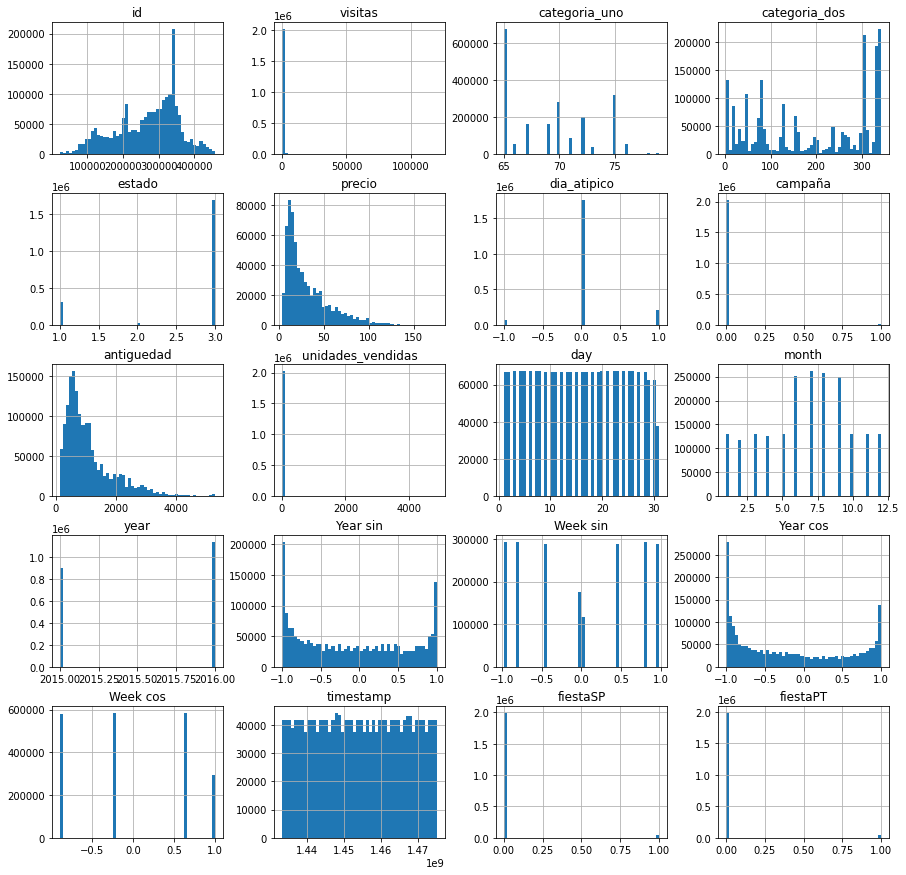

In [ ]:
arrays = df_model_raw.hist(figsize = (15, 15), bins=50)

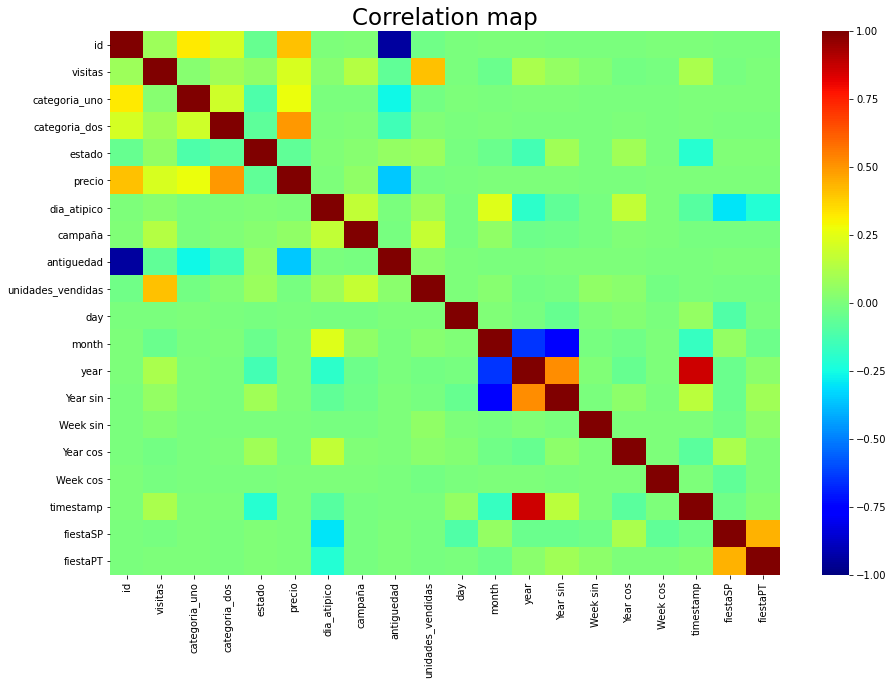

In [ ]:
correlation(df_model_raw)

## 3.2. Fill NaNs

There were specifically 3 columns that had null values. One of them was `precio` (price).The official documentation told us that the price had to be filled in with the value of the closest price to an earlier date for the given product. However, when applying this method, we found that for some products there was no previous price to fill with. At the beginning we decided to fill them with later values, so that we propagate the value to the oldest dates. But almost at the end, we realized that those cases occurred in products that had sales only in the last dates, and their age it was less than the others. So we conclude that those records were only noise and that the product was actually put into the catalog since its first price. So the final decision was deleting records from dates prior to their first prices.

The second column that had nulls was `categoria_dos` (category_two). The documentation did not tell us nothing of how to fill them, so we decided to find out which columns it was related to more, in order to deduce the values. In the correlation map, we observe that the column most related to the latter was the price. This seemed to indicate that the category had to do with how expensive the product was. So our strategy was to order the data by id and price and fill the empty category_two with their close values.

In [ ]:
pad_col = ['precio','antiguedad']
backfill_col = ['antiguedad']

# rellena antiguedad por [fecha, id], categoria 2 por [id, precio]
df_model_filled = fill_nan(df_nan=df_model_raw, pad_columns=pad_col, backfill_columns=backfill_col)
display(df_model_filled)

,fecha,id,visitas,categoria_uno,categoria_dos,estado,precio,dia_atipico,campaña,antiguedad,unidades_vendidas,day,month,year,Year sin,Week sin,Year cos,Week cos,timestamp,fiestaSP,fiestaPT
1,2015-06-01,23910.0,5.0,67.0,170.0,3.0,6.07,0.0,0.0,5241.0,3.0,1.0,6.0,2015.0,0.516251,-0.433884,-0.856437,-0.900969,1.433117e+09,0,0
5,2015-06-01,30014.0,5.0,67.0,63.0,3.0,6.12,0.0,0.0,2954.0,3.0,1.0,6.0,2015.0,0.516251,-0.433884,-0.856437,-0.900969,1.433117e+09,0,0
7,2015-06-01,31180.0,11.0,66.0,224.0,3.0,8.05,0.0,0.0,5310.0,42.0,1.0,6.0,2015.0,0.516251,-0.433884,-0.856437,-0.900969,1.433117e+09,0,0
9,2015-06-01,35732.0,8.0,65.0,263.0,3.0,26.24,0.0,0.0,3069.0,9.0,1.0,6.0,2015.0,0.516251,-0.433884,-0.856437,-0.900969,1.433117e+09,0,0
13,2015-06-01,40850.0,12.0,65.0,34.0,3.0,14.18,0.0,0.0,5159.0,3.0,1.0,6.0,2015.0,0.516251,-0.433884,-0.856437,-0.900969,1.433117e+09,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2040032,2016-09-30,456982.0,6575.0,70.0,336.0,3.0,81.28,0.0,0.0,133.0,30.0,30.0,9.0,2016.0,-0.999825,0.781831,-0.018696,0.623490,1.475194e+09,0,0
2040033,2016-09-30,457416.0,1395.0,70.0,336.0,3.0,50.38,0.0,0.0,130.0,9.0,30.0,9.0,2016.0,-0.999825,0.781831,-0.018696,0.623490,1.475194e+09,0,0
2040034,2016-09-30,457422.0,1080.0,70.0,336.0,1.0,93.77,0.0,0.0,130.0,0.0,30.0,9.0,2016.0,-0.999825,0.781831,-0.018696,0.623490,1.475194e+09,0,0
2040035,2016-09-30,458650.0,1385.0,75.0,340.0,3.0,70.85,0.0,0.0,126.0,0.0,30.0,9.0,2016.0,-0.999825,0.781831,-0.018696,0.623490,1.475194e+09,0,0


## 3.3. Drop duplicates

After filling in NaNs, there were duplicate rows that were not deleted before because of the nulls.

In [ ]:
df_model_nodups = drop_duplicates(df_model_filled)
display(df_model_nodups)

DF raw: 	 (1779590, 21)
DF dups clean: 	 (1769628, 21)


,fecha,id,visitas,categoria_uno,categoria_dos,estado,precio,dia_atipico,campaña,antiguedad,unidades_vendidas,day,month,year,Year sin,Week sin,Year cos,Week cos,timestamp,fiestaSP,fiestaPT
0,2015-06-01,23910.0,5.0,67.0,170.0,3.0,6.07,0.0,0.0,5241.0,3.0,1.0,6.0,2015.0,0.516251,-0.433884,-0.856437,-0.900969,1.433117e+09,0,0
1,2015-06-01,30014.0,5.0,67.0,63.0,3.0,6.12,0.0,0.0,2954.0,3.0,1.0,6.0,2015.0,0.516251,-0.433884,-0.856437,-0.900969,1.433117e+09,0,0
2,2015-06-01,31180.0,11.0,66.0,224.0,3.0,8.05,0.0,0.0,5310.0,42.0,1.0,6.0,2015.0,0.516251,-0.433884,-0.856437,-0.900969,1.433117e+09,0,0
3,2015-06-01,35732.0,8.0,65.0,263.0,3.0,26.24,0.0,0.0,3069.0,9.0,1.0,6.0,2015.0,0.516251,-0.433884,-0.856437,-0.900969,1.433117e+09,0,0
4,2015-06-01,40850.0,12.0,65.0,34.0,3.0,14.18,0.0,0.0,5159.0,3.0,1.0,6.0,2015.0,0.516251,-0.433884,-0.856437,-0.900969,1.433117e+09,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1769623,2016-09-30,456982.0,6575.0,70.0,336.0,3.0,81.28,0.0,0.0,133.0,30.0,30.0,9.0,2016.0,-0.999825,0.781831,-0.018696,0.623490,1.475194e+09,0,0
1769624,2016-09-30,457416.0,1395.0,70.0,336.0,3.0,50.38,0.0,0.0,130.0,9.0,30.0,9.0,2016.0,-0.999825,0.781831,-0.018696,0.623490,1.475194e+09,0,0
1769625,2016-09-30,457422.0,1080.0,70.0,336.0,1.0,93.77,0.0,0.0,130.0,0.0,30.0,9.0,2016.0,-0.999825,0.781831,-0.018696,0.623490,1.475194e+09,0,0
1769626,2016-09-30,458650.0,1385.0,75.0,340.0,3.0,70.85,0.0,0.0,126.0,0.0,30.0,9.0,2016.0,-0.999825,0.781831,-0.018696,0.623490,1.475194e+09,0,0


## 3.4. Age preprocess

Finally, the last column is `antiguedad` (age). The strategy used is similar to the one used for categoria_dos but ordering by date and id. The reason for this that during the analysis, we saw that the number of the id increased as its age decreased, so the older ids are the newest products. So ordering that way, ids that had no antiquity were filled with their neighbors. Then, for each product, was taken its first date and it was increased by 1 for each day that passed.

### 3.4.1. Data for training

In [ ]:
df_model_final = df_model_nodups.copy()
df_model_final = antiguedad_model(df_model_final)
display(df_model_final)

,fecha,id,visitas,categoria_uno,categoria_dos,estado,precio,dia_atipico,campaña,antiguedad,unidades_vendidas,day,month,year,Year sin,Week sin,Year cos,Week cos,timestamp,fiestaSP,fiestaPT
0,2015-06-06,21972.0,1.0,67.0,75.0,3.0,5.84,0.0,0.0,5241.0,3.0,6.0,6.0,2015.0,0.440768,9.749279e-01,-0.897621,-0.222521,1.433549e+09,0,0
1,2015-06-07,21972.0,1.0,67.0,75.0,3.0,5.84,0.0,0.0,5242.0,0.0,7.0,6.0,2015.0,0.425262,4.338837e-01,-0.905070,-0.900969,1.433635e+09,0,0
2,2015-06-08,21972.0,1.0,67.0,75.0,3.0,5.84,0.0,0.0,5243.0,3.0,8.0,6.0,2015.0,0.409630,-4.338837e-01,-0.912252,-0.900969,1.433722e+09,0,0
3,2015-06-09,21972.0,1.0,67.0,75.0,3.0,5.84,0.0,0.0,5244.0,0.0,9.0,6.0,2015.0,0.393877,-9.749279e-01,-0.919163,-0.222521,1.433808e+09,0,0
4,2015-06-10,21972.0,0.0,67.0,75.0,3.0,5.84,0.0,0.0,5245.0,0.0,10.0,6.0,2015.0,0.378007,-7.818315e-01,-0.925803,0.623490,1.433894e+09,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1769623,2016-09-26,458660.0,890.0,75.0,340.0,3.0,68.88,0.0,0.0,155.0,18.0,26.0,9.0,2016.0,-0.996174,-4.338837e-01,-0.087397,-0.900969,1.474848e+09,0,0
1769624,2016-09-27,458660.0,1375.0,75.0,340.0,3.0,68.49,0.0,0.0,156.0,30.0,27.0,9.0,2016.0,-0.997530,-9.749279e-01,-0.070248,-0.222521,1.474934e+09,0,0
1769625,2016-09-28,458660.0,1085.0,75.0,340.0,3.0,68.49,0.0,0.0,157.0,30.0,28.0,9.0,2016.0,-0.998590,-7.818315e-01,-0.053078,0.623490,1.475021e+09,0,0
1769626,2016-09-29,458660.0,1325.0,75.0,340.0,3.0,68.49,0.0,0.0,158.0,3.0,29.0,9.0,2016.0,-0.999356,-5.192230e-13,-0.035892,1.000000,1.475107e+09,0,0


### 3.4.2. Data to predict

In [ ]:
df_estimate_final = antiguedad_estimate(df_model_final, df_estimate_raw)
display(df_estimate_final)

,fecha,id,visitas,categoria_uno,categoria_dos,estado,precio,dia_atipico,campaña,antiguedad,day,month,year,Year sin,Week sin,Year cos,Week cos,timestamp,fiestaSP,fiestaPT
0,2016-10-01,21972.0,5.0,67.0,75.0,3.0,5.84,0.0,0.0,5724.0,1.0,10.0,2016.0,-0.999999,9.749279e-01,-0.001494,-0.222521,1.475280e+09,0,0
1,2016-10-02,21972.0,15.0,67.0,75.0,3.0,5.84,0.0,0.0,5725.0,2.0,10.0,2016.0,-0.999877,4.338837e-01,0.015708,-0.900969,1.475366e+09,0,0
2,2016-10-03,21972.0,5.0,67.0,75.0,3.0,5.84,0.0,0.0,5726.0,3.0,10.0,2016.0,-0.999458,-4.338837e-01,0.032905,-0.900969,1.475453e+09,0,0
3,2016-10-04,21972.0,5.0,67.0,75.0,3.0,5.84,0.0,0.0,5727.0,4.0,10.0,2016.0,-0.998745,-9.749279e-01,0.050093,-0.222521,1.475539e+09,0,0
4,2016-10-05,21972.0,0.0,67.0,75.0,3.0,5.84,0.0,0.0,5728.0,5.0,10.0,2016.0,-0.997735,-7.818315e-01,0.067266,0.623490,1.475626e+09,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212836,2016-12-26,458660.0,1085.0,75.0,340.0,3.0,70.85,1.0,0.0,246.0,26.0,12.0,2016.0,-0.092719,-4.338837e-01,0.995692,-0.900969,1.482710e+09,1,0
212837,2016-12-27,458660.0,965.0,75.0,340.0,3.0,70.85,1.0,0.0,247.0,27.0,12.0,2016.0,-0.075577,-9.749279e-01,0.997140,-0.222521,1.482797e+09,0,0
212838,2016-12-28,458660.0,1005.0,75.0,340.0,3.0,70.85,1.0,0.0,248.0,28.0,12.0,2016.0,-0.058413,-7.818315e-01,0.998292,0.623490,1.482883e+09,0,0
212839,2016-12-29,458660.0,745.0,75.0,340.0,3.0,70.85,1.0,0.0,249.0,29.0,12.0,2016.0,-0.041232,7.920970e-13,0.999150,1.000000,1.482970e+09,0,0


## 3.5. Save the preprocessed data

In [ ]:
save_pickle(DIR_DATASET_BASE, f'df_model_filled_nodups_antiguedad', df_model_final)
save_pickle(DIR_DATASET_BASE, f'df_estimate_filled_nodups_antiguedad', df_estimate_final)

## 3.6. Import the preprocessed data

In [ ]:
drive.mount('/content/drive', force_remount=True)
df_model_final    = load_pickle(DIR_DATASET_BASE, f'df_model_filled_nodups_antiguedad')
df_estimate_final = load_pickle(DIR_DATASET_BASE, f'df_estimate_filled_nodups_antiguedad')

print(df_model_final.shape)
print(df_estimate_final.shape)

Mounted at /content/drive
(1769628, 21)
(212841, 20)


## 3.7. Split train, val, test

Split data in 60% train, 20% valid, 20% test and grouped by id in order to have all ids in each slice

In [ ]:
pct = 0.2 # valid and test %

df_model_final.sort_values(['fecha','id'], inplace=True, axis=0, ignore_index=True)

df_train = pd.DataFrame(columns=df_model_final.columns)
df_val   = pd.DataFrame(columns=df_model_final.columns)
df_test  = pd.DataFrame(columns=df_model_final.columns)

id_uniques = df_model_final['id'].unique()

for id in id_uniques:
  df_id = df_model_final[df_model_final['id'] == id].copy()
  val_size    = int(pct * len(df_id)) 
  train_end   = int(len(df_id) - val_size * 2)
  
  df_train_id = df_id[ :train_end]
  df_val_id   = df_id[train_end : train_end+val_size]
  df_test_id  = df_id[train_end+val_size: ]

  df_train = pd.concat([df_train, df_train_id])
  df_val   = pd.concat([df_val, df_val_id])
  df_test  = pd.concat([df_test, df_test_id])

df_train.sort_values(['fecha','id'], inplace=True, axis=0, ignore_index=True)
df_val.sort_values(['fecha','id'], inplace=True, axis=0, ignore_index=True)
df_test.sort_values(['fecha','id'], inplace=True, axis=0, ignore_index=True)

display(df_train.shape)
display(df_val.shape)
display(df_test.shape)
print(len(df_train['id'].unique()), len(df_val['id'].unique()), len(df_test['id'].unique()))
print(len(df_train['fecha'].unique()), len(df_val['fecha'].unique()), len(df_test['fecha'].unique()))

(1065158, 21)

(352235, 21)

(352235, 21)

4168 4168 4168
477 189 97


### 3.7.1. Save splits

In [ ]:
save_pickle(DIR_DATASET_BASE, 'df_train', df_train)
save_pickle(DIR_DATASET_BASE, 'df_val', df_val)
save_pickle(DIR_DATASET_BASE, 'df_test', df_test)

## 3.8. Import splits

In [ ]:
df_train = load_pickle(DIR_DATASET_BASE, 'df_train')
df_val = load_pickle(DIR_DATASET_BASE, 'df_val')
df_test = load_pickle(DIR_DATASET_BASE, 'df_test')

display(df_train.shape)
display(df_val.shape)
display(df_test.shape)

(1065158, 21)

(352235, 21)

(352235, 21)

## 3.9. Scale data
I would like to mention an approach that we did not realize was to scale the data by seasons since there were seasons with higher average visits and sales. In our case we always scale all the data together and try to eliminate the extreme values

In [ ]:
APPEND_SCALED = False # if append or replace inplace scaled data
SCALE_X = True
SCALE_Y = False
scalerX = None
scalerY = None

cols_to_scale = df_train.columns 
cols_to_scale = cols_to_scale.drop(['fecha', "unidades_vendidas", 'timestamp', 'Year sin', 'Week sin', 'Year cos', 'Week cos'])

df_train.sort_values(['fecha','id'], inplace=True, axis=0, ignore_index=True)
df_val.sort_values(['fecha','id'], inplace=True, axis=0, ignore_index=True)
df_test.sort_values(['fecha','id'], inplace=True, axis=0, ignore_index=True)
df_estimate_final.sort_values(['fecha','id'], inplace=True, axis=0, ignore_index=True)

df_train_scaled    = df_train.copy()
df_val_scaled      = df_val.copy()
df_test_scaled     = df_test.copy()
df_estimate_scaled = df_estimate_final.copy()

if SCALE_X:  
  scalerX = MinMaxScaler(feature_range=(0, 1))
  scalerX, df_train_scaled     = scale(df_train_scaled, cols_to_scale=cols_to_scale, scaler=scalerX, fit=True, append_scaled=APPEND_SCALED)
  scalerX, df_val_scaled       = scale(df_val_scaled, cols_to_scale=cols_to_scale, scaler=scalerX, fit=False, append_scaled=APPEND_SCALED)
  scalerX, df_test_scaled      = scale(df_test_scaled, cols_to_scale=cols_to_scale, scaler=scalerX, fit=False, append_scaled=APPEND_SCALED)
  scalerX, df_estimate_scaled  = scale(df_estimate_scaled, cols_to_scale=cols_to_scale, scaler=scalerX, fit=False, append_scaled=APPEND_SCALED)

if SCALE_Y:
  scalerY = ZScore()
  scalerY, df_train_scaled = scale(df_train_scaled, cols_to_scale=['unidades_vendidas'], scaler=scalerY, fit=True)
  scalerY, df_val_scaled   = scale(  df_val_scaled, cols_to_scale=['unidades_vendidas'], scaler=scalerY, fit=False)
  scalerY, df_test_scaled  = scale( df_test_scaled, cols_to_scale=['unidades_vendidas'], scaler=scalerY, fit=False)

display(df_train_scaled.shape)
display(df_val_scaled.shape)
display(df_test_scaled.shape)

Fit: True


(1065158, 21)

(352235, 21)

(352235, 21)

In [ ]:
display(df_train_scaled)

,id,visitas,categoria_uno,categoria_dos,estado,precio,dia_atipico,campaña,antiguedad,day,month,year,fiestaSP,fiestaPT,fecha,unidades_vendidas,Year sin,Week sin,Year cos,Week cos,timestamp
0,0.004438,0.000043,0.142857,0.492669,1.0,0.011187,0.5,0.0,0.933905,0.000000,0.454545,0.0,0.0,0.0,2015-06-01,3.0,0.516251,-0.433884,-0.856437,-0.900969,1.433117e+09
1,0.018416,0.000043,0.142857,0.178886,1.0,0.011478,0.5,0.0,0.516341,0.000000,0.454545,0.0,0.0,0.0,2015-06-01,3.0,0.516251,-0.433884,-0.856437,-0.900969,1.433117e+09
2,0.021086,0.000096,0.071429,0.651026,1.0,0.022723,0.5,0.0,0.946504,0.000000,0.454545,0.0,0.0,0.0,2015-06-01,42.0,0.516251,-0.433884,-0.856437,-0.900969,1.433117e+09
3,0.031510,0.000069,0.000000,0.765396,1.0,0.128707,0.5,0.0,0.537338,0.000000,0.454545,0.0,0.0,0.0,2015-06-01,9.0,0.516251,-0.433884,-0.856437,-0.900969,1.433117e+09
4,0.043230,0.000104,0.000000,0.093842,1.0,0.058440,0.5,0.0,0.918934,0.000000,0.454545,0.0,0.0,0.0,2015-06-01,3.0,0.516251,-0.433884,-0.856437,-0.900969,1.433117e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1065153,0.997165,0.056800,0.357143,0.979472,1.0,0.522170,0.5,0.0,0.003286,0.566667,0.727273,1.0,0.0,0.0,2016-09-18,42.0,-0.974765,0.433884,-0.223234,-0.900969,1.474157e+09
1065154,0.999977,0.013636,0.714286,0.991202,1.0,0.388627,0.5,0.0,0.003652,0.566667,0.727273,1.0,0.0,0.0,2016-09-18,15.0,-0.974765,0.433884,-0.223234,-0.900969,1.474157e+09
1065155,1.000000,0.010813,0.714286,0.991202,1.0,0.388627,0.5,0.0,0.003834,0.566667,0.727273,1.0,0.0,0.0,2016-09-18,21.0,-0.974765,0.433884,-0.223234,-0.900969,1.474157e+09
1065156,0.997165,0.052284,0.357143,0.979472,1.0,0.522170,0.5,0.0,0.003469,0.600000,0.727273,1.0,0.0,0.0,2016-09-19,21.0,-0.978461,-0.433884,-0.206433,-0.900969,1.474243e+09


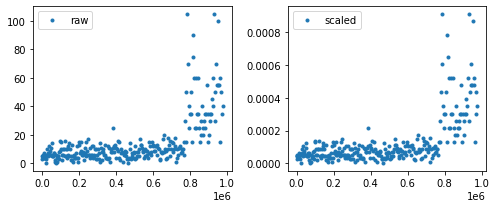

In [ ]:
fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(7, 3))
_ = axs[0].plot(df_train[df_train['id'] == df_train.loc[0,'id']]['visitas'], '.', label='raw')
_ = axs[1].plot(df_train_scaled[df_train_scaled['id'] == df_train_scaled.loc[0,'id']]['visitas'], '.', label='scaled')
for ax in axs:
  ax.legend()

## 3.10. Split labels from data. X,y

In [ ]:
df_train_xy = df_train_scaled.copy()
df_val_xy   = df_val_scaled.copy()
df_test_xy  = df_test_scaled.copy()

df_train_xy.sort_values(['id','fecha'], axis=0, inplace=True, ignore_index=True)
df_val_xy.sort_values(['id','fecha'], axis=0, inplace=True, ignore_index=True)
df_test_xy.sort_values(['id','fecha'], axis=0, inplace=True, ignore_index=True)

tipo_red = 3
X_train, y_train = split_xy(df_train_xy, kind=tipo_red, train=True)
X_val, y_val     = split_xy(df_val_xy, kind=tipo_red, train=True)
X_test, y_test   = split_xy(df_test_xy, kind=tipo_red,train=True)

print(f'X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}')
print(f'X_val.shape: {X_val.shape}, y_val.shape: {y_val.shape}')
print(f'X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape}')

X_train.shape: (1065158, 18), y_train.shape: (1065158, 1)
X_val.shape: (352235, 18), y_val.shape: (352235, 1)
X_test.shape: (352235, 18), y_test.shape: (352235, 1)


# 4. Show final training data

In [ ]:
print(f'train.min: {np.amin(X_train.values)}, train.max: {np.amax(X_train.values)}')
print(f'val.min: {np.amin(X_val.values)}, val.max: {np.amax(X_val.values)}')
print(f'test.min: {np.amin(X_test.values)}, test.max: {np.amax(X_test.values)}')

display(X_train)
display(y_train)

train.min: -0.9999964163499203, train.max: 1.0
val.min: -0.9999925921414804, val.max: 1.0426003126628451
test.min: -0.9999925921414804, test.max: 1.0354208508307468


,id,visitas,categoria_uno,categoria_dos,estado,precio,dia_atipico,campaña,antiguedad,day,month,year,fiestaSP,fiestaPT,Year sin,Week sin,Year cos,Week cos
0,0.004438,0.000043,0.142857,0.492669,1.0,0.011187,0.5,0.0,0.933905,0.000000,0.454545,0.0,0.0,0.0,0.516251,-0.433884,-0.856437,-0.900969
1,0.018416,0.000043,0.142857,0.178886,1.0,0.011478,0.5,0.0,0.516341,0.000000,0.454545,0.0,0.0,0.0,0.516251,-0.433884,-0.856437,-0.900969
2,0.021086,0.000096,0.071429,0.651026,1.0,0.022723,0.5,0.0,0.946504,0.000000,0.454545,0.0,0.0,0.0,0.516251,-0.433884,-0.856437,-0.900969
3,0.031510,0.000069,0.000000,0.765396,1.0,0.128707,0.5,0.0,0.537338,0.000000,0.454545,0.0,0.0,0.0,0.516251,-0.433884,-0.856437,-0.900969
4,0.043230,0.000104,0.000000,0.093842,1.0,0.058440,0.5,0.0,0.918934,0.000000,0.454545,0.0,0.0,0.0,0.516251,-0.433884,-0.856437,-0.900969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1065153,0.997165,0.056800,0.357143,0.979472,1.0,0.522170,0.5,0.0,0.003286,0.566667,0.727273,1.0,0.0,0.0,-0.974765,0.433884,-0.223234,-0.900969
1065154,0.999977,0.013636,0.714286,0.991202,1.0,0.388627,0.5,0.0,0.003652,0.566667,0.727273,1.0,0.0,0.0,-0.974765,0.433884,-0.223234,-0.900969
1065155,1.000000,0.010813,0.714286,0.991202,1.0,0.388627,0.5,0.0,0.003834,0.566667,0.727273,1.0,0.0,0.0,-0.974765,0.433884,-0.223234,-0.900969
1065156,0.997165,0.052284,0.357143,0.979472,1.0,0.522170,0.5,0.0,0.003469,0.600000,0.727273,1.0,0.0,0.0,-0.978461,-0.433884,-0.206433,-0.900969


,unidades_vendidas
0,3.0
1,3.0
2,42.0
3,9.0
4,3.0
...,...
1065153,42.0
1065154,15.0
1065155,21.0
1065156,21.0


# 5. Training pipeline

## 5.1. Definitions

### 5.1.1. Metrics.

In [ ]:
def SMAPE(y_true, y_pred):
  y_pred = ops.convert_to_tensor_v2_with_dispatch(y_pred)
  y_true = math_ops.cast(y_true, y_pred.dtype)

  nom = tf.math.abs(y_pred-y_true)                 
  denom = tf.maximum(tf.math.abs(y_pred) + tf.math.abs(y_true), tf.constant([0.00001], dtype=nom.dtype))
  denom = tf.divide(denom, 2.0)
  results = tf.divide(nom, denom)    
  results = 100.0 * tf.reduce_mean(results)

  return results 

def casos_favorables(y_true, y_pred):
  cfs = tf.math.less_equal(y_true, y_pred)  
  cfs = tf.cast(cfs, tf.int32)  

  cfs = tf.math.reduce_sum(cfs)    
  cfs = tf.cast(cfs, y_true.dtype)
  
  size = tf.cast( tf.size(y_true), y_true.dtype )
  return tf.divide(cfs, size)

def rRMSE(y_true, y_pred):
  y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float32)
  y_true = tf.cast(y_true, y_pred.dtype)

  pows = tf.math.pow( (y_true-y_pred), 2.0 )
  sum  = tf.reduce_sum(pows)
  mse  = tf.divide( sum, tf.cast(tf.size(y_pred), y_true.dtype) )
  rmse = tf.sqrt( mse )
  mean = tf.reduce_mean(y_true)

  rrmse   = tf.divide(rmse, mean)
  cf      = casos_favorables(y_true, y_pred)
  results = (0.7 * rrmse) + (0.3 * (1.0 - cf))

  return results    

###5.1.2. Plots

In [ ]:
def histories_mean(histories, divisor, mean):  
  history_array = np.array(histories)
  history_mean = history_array[0]
  size = len(histories[0].history['loss'])

  if (not mean):
    return history_mean

  for i in range(size):
    for j in range(1, divisor):    
      history_mean.history['loss'][i] += history_array[j].history['loss'][i]
      history_mean.history['val_loss'][i] += history_array[j].history['val_loss'][i]

  for i in range(size):
    history_mean.history['loss'][i] /= divisor
    history_mean.history['val_loss'][i] /= divisor

  return history_mean

# plot diagnostic learning curves
def plot_learning_curves(histories, title, mean_divisor, mean=False):		 
  history_mean = histories_mean(histories, mean_divisor, mean)		
 
  fig = plt.figure(figsize=(15, 5))

  # Loss plots
  ax1 = fig.add_subplot(1, 3, 1)
  ax1.set_title('Loss')
  ax1.set_xlabel('epochs')
  ax1.set_ylabel('loss')
  ax1.plot(history_mean.history['loss'], color='blue', label='train')
  ax1.plot(history_mean.history['val_loss'], color='orange', label='validation')

  # SMAPE metric plot
  ax2 = fig.add_subplot(1, 3, 2)
  ax2.set_title('Metric SMAPE')
  ax2.set_xlabel('epochs')
  ax2.set_ylabel('smape')
  ax2.plot(history_mean.history['SMAPE'], color='blue', label='train')
  ax2.plot(history_mean.history['val_SMAPE'], color='orange', label='validation')

  ax2 = fig.add_subplot(1, 3, 3)
  ax2.set_title('Metric rRMSE')
  ax2.set_xlabel('epochs')
  ax2.set_ylabel('rRMSE')
  ax2.plot(history_mean.history['rRMSE'], color='blue', label='train')
  ax2.plot(history_mean.history['val_rRMSE'], color='orange', label='validation')

  plt.subplots_adjust(top=0.85, bottom=0.10, left=0.05, right=0.95, hspace=0.5, wspace=0.40)

  plt.legend()
  plt.suptitle(title)
  # plt.savefig(f'{DIR_LEARNING_CURVES}/lc_{title}.png')
  plt.show()


## 5.2. Neural Architectures

### 5.0. BaseModel. DenseBlock.

In [ ]:
class BaseModel:
  def __init__(self, input_size, output_size, kernel_regularizer=None, batch_norm=False):
    self.input_size           = input_size
    self.output_size          = output_size
    self.batch_norm           = batch_norm
    self.kernel_regularizer   = kernel_regularizer 

  def custom_activation(self, activation_function):
    if isinstance(activation_function, str):
      return Activation(activation_function)
    else:
      return activation_function  

  def seq_dense_block(self, size, activation, kernel_regularizer=None, batch_norm=False, use_bias=True, drop_out=None):
    initializer = he_uniform(518)

    result = keras.Sequential()
    result.add(
      Dense(
          size
        , kernel_regularizer=kernel_regularizer
        , kernel_initializer=initializer
        , use_bias=use_bias
      )
    )
    
    if batch_norm:
      result.add(BatchNormalization())
    
    result.add(self.custom_activation(activation))

    if drop_out is not None:
      result.add(Dropout(drop_out))
    return result  

  def generator(self):
    return self.seq_generator()

### 5.2.1. Feedforward.

In [ ]:
class Feedforward(BaseModel):
  def __init__(self, input_size, output_size, kernel_regularizer=None, batch_norm=False):    
    BaseModel.__init__(self, input_size, output_size, kernel_regularizer, batch_norm)  

  def seq_generator(self):
    dense_stack = [
        self.seq_dense_block(8, ReLU(), self.kernel_regularizer, self.batch_norm, drop_out=0.1)  
      , self.seq_dense_block(8, ReLU(), self.kernel_regularizer, self.batch_norm, drop_out=0.1)  
      , self.seq_dense_block(8, ReLU(), self.kernel_regularizer, self.batch_norm, drop_out=0.1)  
      , self.seq_dense_block(8, ReLU(), self.kernel_regularizer, self.batch_norm, drop_out=0.1)  
    ]

    inputs = tf.keras.layers.Input(shape=self.input_size)
    x = inputs 

    for dense in dense_stack:
      x = dense(x)  

    last = self.seq_dense_block(self.output_size, ReLU())
    x = last(x)
    
    return keras.Model(inputs=inputs, outputs=x, name='SeqFeedforward')

### 5.2.2. DenseResidual.

In [ ]:
class DenseResidual(BaseModel):
  def __init__(self, input_size, output_size, kernel_regularizer=None, batch_norm=False):    
    BaseModel.__init__(self, input_size, output_size, kernel_regularizer, batch_norm)  

  def seq_generator(self):
    down_stack = [
        self.seq_dense_block(512, LeakyReLU(), self.kernel_regularizer, self.batch_norm, use_bias=False, drop_out=0.2)  
      , self.seq_dense_block(512, LeakyReLU(), self.kernel_regularizer, self.batch_norm, use_bias=False, drop_out=0.2)        
      , self.seq_dense_block(256, LeakyReLU(), self.kernel_regularizer, self.batch_norm, use_bias=False, drop_out=0.2)  
      , self.seq_dense_block(128, LeakyReLU(), self.kernel_regularizer, self.batch_norm, use_bias=False, drop_out=0.2)  
      , self.seq_dense_block(64,  LeakyReLU(), self.kernel_regularizer, self.batch_norm, use_bias=False, drop_out=0.2)      
    ]

    up_stack = [
        self.seq_dense_block(64,  ReLU(), self.kernel_regularizer, self.batch_norm, drop_out=0.2)  
      , self.seq_dense_block(128, ReLU(), self.kernel_regularizer, self.batch_norm, drop_out=0.2)  
      , self.seq_dense_block(256, ReLU(), self.kernel_regularizer, self.batch_norm, drop_out=0.2)  
      , self.seq_dense_block(512, ReLU(), self.kernel_regularizer, self.batch_norm, drop_out=0.2)  
    ]

    inputs = tf.keras.layers.Input(shape=self.input_size)
    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
      x = down(x)
      skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
      x = up(x)
      concat = tf.keras.layers.Concatenate()
      x = concat([x, skip])

    last = self.seq_dense_block(self.output_size, ReLU())
    x = last(x)
    
    return keras.Model(inputs=inputs, outputs=x, name='SeqDenseResidual')

### 5.2.3. LSTM.

In [ ]:
class RecurrentLSTM(BaseModel):
  def __init__(self, input_size, output_size, kernel_regularizer=None, batch_norm=False):    
    BaseModel.__init__(self, input_size, output_size, kernel_regularizer, batch_norm) 

  def seq_lstm_block(self, size, activation, return_sequences=False, batch_norm=False, drop_out=None):
    initializer = he_uniform(518) 

    result = keras.Sequential()
    result.add(LSTM(
          size
        , activation=None
        , kernel_initializer=initializer
        , recurrent_initializer=initializer
        , return_sequences=return_sequences
        , kernel_regularizer=self.kernel_regularizer
    ))
    
    result.add(self.custom_activation(activation))

    if self.batch_norm:
      result.add(BatchNormalization())

    if drop_out is not None:
      result.add(layers.Dropout(drop_out))

    return result

  def seq_generator(self):
    recurrent_stack = [
        self.seq_lstm_block(8, ReLU(), True, self.batch_norm, drop_out=None)
      , self.seq_lstm_block(8, ReLU(), True, self.batch_norm, drop_out=None)
      , self.seq_lstm_block(8, ReLU(), True, self.batch_norm, drop_out=None)
      , self.seq_lstm_block(8, ReLU(), False, self.batch_norm, drop_out=None)
    ] 

    dense_stack = [
        self.seq_dense_block(8, ReLU(), self.kernel_regularizer, self.batch_norm, drop_out=None)  
      , self.seq_dense_block(8, ReLU(), self.kernel_regularizer, self.batch_norm, drop_out=None)  
      # , self.seq_dense_block(8, ReLU(), self.kernel_regularizer, self.batch_norm, drop_out=None)  
      # , self.seq_dense_block(8, ReLU(), self.kernel_regularizer, self.batch_norm, drop_out=None)  
    ]

    inputs = tf.keras.layers.Input(shape=self.input_size)
    x = inputs

    for recurrent in recurrent_stack:
      x = recurrent(x)    

    for dense in dense_stack:
      x = dense(x)    

    last = self.seq_dense_block(self.output_size, ReLU())
    x = last(x)
    
    return keras.Model(inputs=inputs, outputs=x, name='SeqRecurrentLSTM')


### 5.2.4. Residual LSTM.

In [ ]:
class ResidualLSTM(RecurrentLSTM):
  def __init__(self, input_size, output_size, kernel_regularizer=None, batch_norm=False):    
    BaseModel.__init__(self, input_size, output_size, kernel_regularizer, batch_norm) 

  def seq_generator(self):
    down_stack = [
        self.seq_lstm_block(512, ReLU(), True, self.batch_norm)
      , self.seq_lstm_block(512, ReLU(), True, self.batch_norm)
      , self.seq_lstm_block(256, ReLU(), True, self.batch_norm)
      , self.seq_lstm_block(128, ReLU(), True, self.batch_norm)
      , self.seq_lstm_block(64,  ReLU(), True, self.batch_norm)
    ]

    up_stack = [
        self.seq_lstm_block(64,  ReLU(), True, self.batch_norm)
      , self.seq_lstm_block(128, ReLU(), True, self.batch_norm)
      , self.seq_lstm_block(256, ReLU(), True, self.batch_norm)
      , self.seq_lstm_block(512, ReLU(), True, self.batch_norm)
    ]

    inputs = tf.keras.layers.Input(shape=self.input_size)
    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
      x = down(x)
      skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
      x = up(x)
      concat = tf.keras.layers.Concatenate()
      x = concat([x, skip])    

    x = self.seq_lstm_block(512, ReLU(), False, self.batch_norm)(x)    
    last = self.seq_dense_block(self.output_size, ReLU())
    x = last(x)
    
    return keras.Model(inputs=inputs, outputs=x, name='SeqResidualLSTM')

##5.3 Training

###5.3.1. Neural networks

Epoch 1/10
4161/4161 [==============================] - 16s 3ms/step - loss: 427.1993 - SMAPE: 144.4138 - rRMSE: 2.3067 - val_loss: 193.4310 - val_SMAPE: 164.6281 - val_rRMSE: 2.3925
Epoch 2/10
4161/4161 [==============================] - 14s 3ms/step - loss: 417.4230 - SMAPE: 146.5076 - rRMSE: 2.2381 - val_loss: 191.7535 - val_SMAPE: 159.6304 - val_rRMSE: 2.4805
Epoch 3/10
4161/4161 [==============================] - 12s 3ms/step - loss: 413.6184 - SMAPE: 143.3133 - rRMSE: 2.2313 - val_loss: 189.7740 - val_SMAPE: 158.6857 - val_rRMSE: 2.4636
Epoch 4/10
4161/4161 [==============================] - 14s 3ms/step - loss: 410.8059 - SMAPE: 141.5279 - rRMSE: 2.2305 - val_loss: 188.3569 - val_SMAPE: 158.4156 - val_rRMSE: 2.4302
Epoch 5/10
4161/4161 [==============================] - 14s 3ms/step - loss: 408.7843 - SMAPE: 140.1015 - rRMSE: 2.2255 - val_loss: 187.6532 - val_SMAPE: 154.5244 - val_rRMSE: 2.4256
Epoch 6/10
4161/4161 [==============================] - 12s 3ms/step - loss: 407.5015

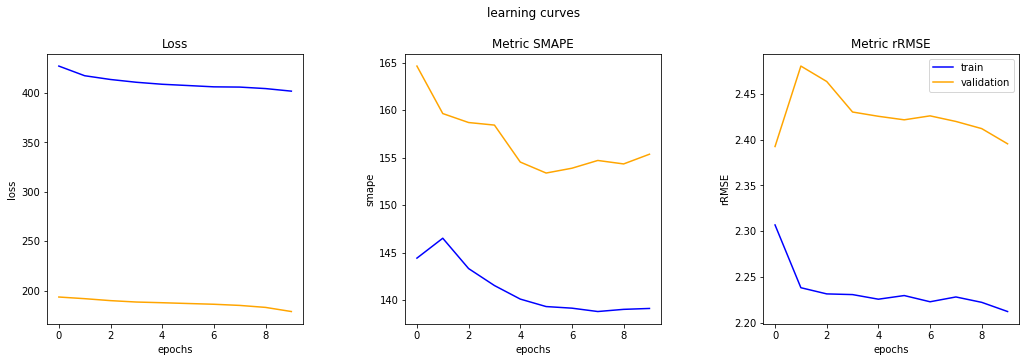

In [ ]:
LR_DECAY      = tf.optimizers.schedules.ExponentialDecay(initial_learning_rate=2e-4, decay_steps=1e5, decay_rate=0.8)
OPTIMIZER     = tf.keras.optimizers.Adam(LR_DECAY, beta_1=0.5, beta_2=0.999, epsilon=1e-07, amsgrad=False) 
KERNEL_REGULARIZER  = tf.keras.regularizers.l2(5e-5)
OUTPUT_SIZE = y_train.shape[-1] if len(y_train.shape) > 1 else 1

epochs = 10
batch_size = 256
LOSS          = 'mse'
METRICS       = [ SMAPE,rRMSE ]

model = Feedforward(X_train.shape[1:], OUTPUT_SIZE, kernel_regularizer=KERNEL_REGULARIZER, batch_norm=True).generator()
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS) 

history = model.fit(
      X_train
    , y_train
    , batch_size=batch_size
    , epochs=epochs
    # , validation_split=0.1
    , validation_data=(X_val, y_val)
    , verbose=1, shuffle=True
    )

histories = list()
histories.append(history)

plot_learning_curves(histories, "learning curves", 1, mean=False)

### 5.3.2 Trees 

In [ ]:
from sklearn.ensemble import VotingRegressor, GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
# !pip install catboost
# from catboost import CatBoostRegressor
# import xgboost
# from xgboost import XGBRegressor

# model = CatBoostRegressor(iterations=1000, task_type="GPU", devices='0:1') #2.7 / 2.4
# model = XGBRegressor(max_depth=5, min_child_weight=1,  n_estimators=100, n_jobs=-1 , verbose=2,learning_rate=0.16)
# gbm = XGBRegressor()
# model = GridSearchCV(gbm, {"colsample_bytree":[1.0],
#                             "min_child_weight":[1.0,1.2] ,
#                             'max_depth': [3,4,5,6], 
#                             'n_estimators': [100, 200, 500],
#                            'learning_rate' : [0.05, 0.1, 0.15]}, verbose=1, n_jobs=-1)

# model = DecisionTreeRegressor(random_state=0,max_depth=10)
# model = MLPRegressor(random_state=1, max_iter=500, early_stopping=True, verbose=True) # 2.52 val, 2.3 train aun se podria mejorar

# model = GradientBoostingRegressor(max_depth=19, learning_rate=0.1, random_state=1, verbose=2) #depth=3
# reg2 = RandomForestRegressor(max_depth=4,  random_state=517, verbose=2, n_jobs=-1, bootstrap=True) #depth=4
# reg3 = LinearRegression( n_jobs=-1)
# model = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2 ), ('ln', reg3 )], n_jobs=-1)

model = ExtraTreesRegressor(max_depth=19, n_estimators=95 ,random_state=40, verbose=2, n_jobs=-1, bootstrap=True)

start_time = time.time()
model = model.fit(X_train, y_train)
print(f"--- {(time.time() - start_time)/60.} minutes ---")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 95
building tree 2 of 95
building tree 3 of 95
building tree 4 of 95
building tree 5 of 95
building tree 6 of 95
building tree 7 of 95
building tree 8 of 95
building tree 9 of 95
building tree 10 of 95
building tree 11 of 95
building tree 12 of 95
building tree 13 of 95
building tree 14 of 95
building tree 15 of 95
building tree 16 of 95
building tree 17 of 95
building tree 18 of 95
building tree 19 of 95
building tree 20 of 95
building tree 21 of 95
building tree 22 of 95
building tree 23 of 95
building tree 24 of 95
building tree 25 of 95
building tree 26 of 95
building tree 27 of 95
building tree 28 of 95
building tree 29 of 95
building tree 30 of 95
building tree 31 of 95
building tree 32 of 95
building tree 33 of 95
building tree 34 of 95
building tree 35 of 95
building tree 36 of 95
building tree 37 of 95
building tree 38 of 95


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.0min


building tree 39 of 95
building tree 40 of 95
building tree 41 of 95
building tree 42 of 95
building tree 43 of 95
building tree 44 of 95
building tree 45 of 95
building tree 46 of 95
building tree 47 of 95
building tree 48 of 95
building tree 49 of 95
building tree 50 of 95
building tree 51 of 95
building tree 52 of 95
building tree 53 of 95
building tree 54 of 95
building tree 55 of 95
building tree 56 of 95
building tree 57 of 95
building tree 58 of 95
building tree 59 of 95
building tree 60 of 95
building tree 61 of 95
building tree 62 of 95
building tree 63 of 95
building tree 64 of 95
building tree 65 of 95
building tree 66 of 95
building tree 67 of 95
building tree 68 of 95
building tree 69 of 95
building tree 70 of 95
building tree 71 of 95
building tree 72 of 95
building tree 73 of 95
building tree 74 of 95
building tree 75 of 95
building tree 76 of 95
building tree 77 of 95
building tree 78 of 95
building tree 79 of 95
building tree 80 of 95
building tree 81 of 95
building tr

[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:  5.0min finished


## 5.4. Predictions and visualization

### 5.4.1. Prediction

In [ ]:
y_pred_train  = model.predict(X_train) 
y_pred        = model.predict(X_val) 

y_pred = pd.DataFrame(y_pred, columns=['unidades_vendidas'])
y_pred_train = pd.DataFrame(y_pred_train, columns=['unidades_vendidas'])

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    4.8s
[Parallel(n_jobs=2)]: Done  95 out of  95 | elapsed:   11.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    1.5s
[Parallel(n_jobs=2)]: Done  95 out of  95 | elapsed:    3.8s finished


### 5.4.2. Visualization

SCALED Y: False
TRAIN
mse: 88.49332
smape: 105.80892
rrmse: 1.50387
VAL
mse: 108.74516
smape: 102.84485
rrmse: 2.33607


array([11.,  4., 39.,  2.,  8.,  0.,  3.,  5.,  7.,  3.])

array([ 6.,  0., 24.,  6.,  0.,  0.,  0.,  3.,  6.,  9.])

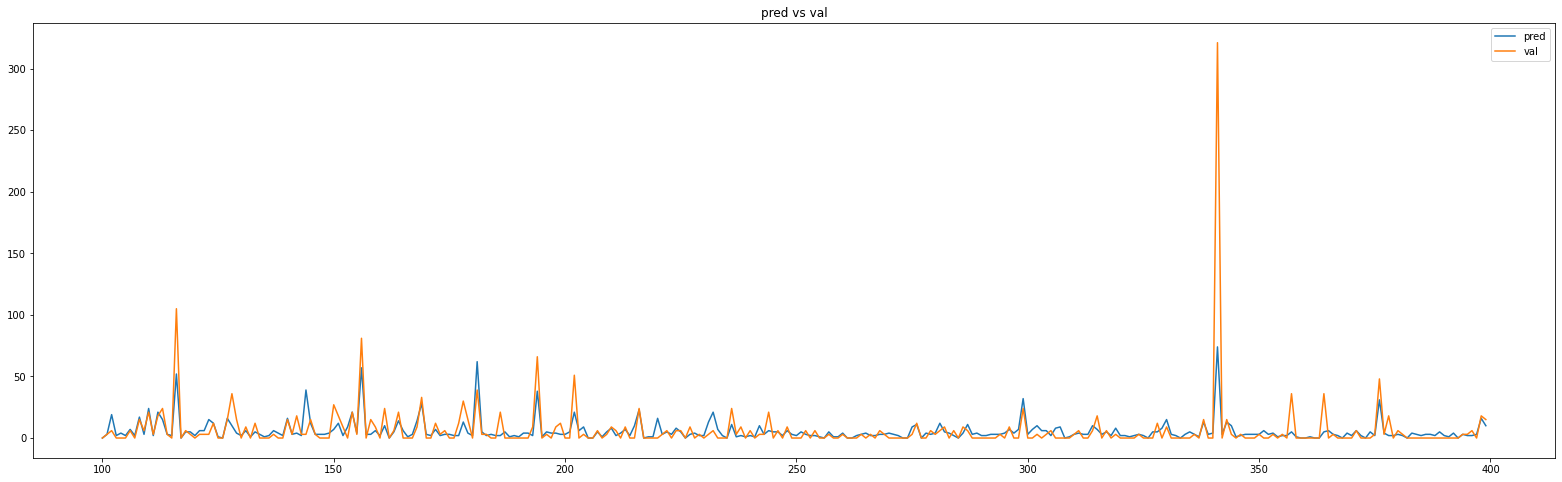

In [ ]:
df_y_pred = pd.DataFrame(data=y_pred)
df_y_pred_train = pd.DataFrame(data=y_pred_train)
df_y_val = pd.DataFrame(data=y_val)
df_y_train = pd.DataFrame(data=y_train)
df_y_val.reset_index(inplace=True, drop=True)

print(f'SCALED Y: {SCALE_Y}')
if SCALE_Y:
  df_y_pred       = pd.DataFrame(scalerY.inverse_transform(df_y_pred), columns=df_y_pred.columns)
  df_y_pred_train = pd.DataFrame(scalerY.inverse_transform(df_y_pred_train), columns=df_y_pred.columns)
  df_y_val        = pd.DataFrame(scalerY.inverse_transform(df_y_val), columns=df_y_pred.columns)
  df_y_train      = pd.DataFrame(scalerY.inverse_transform(y_train.copy()), columns=df_y_pred.columns)

df_y_pred = pd.DataFrame(np.around(tf.keras.activations.relu(df_y_pred).numpy()), columns=['unidades_vendidas'])
df_y_pred_train = pd.DataFrame(np.around(tf.keras.activations.relu(df_y_pred_train).numpy()), columns=['unidades_vendidas'])

print("TRAIN")
print(f'mse: {tf.reduce_mean(tf.keras.losses.mean_squared_error(df_y_train, df_y_pred_train)):.5f}')
print(f'smape: {SMAPE(df_y_train, df_y_pred_train):.5f}')
print(f'rrmse: {rRMSE(df_y_train, df_y_pred_train):.5f}')

print("VAL")
print(f'mse: {tf.reduce_mean(tf.keras.losses.mean_squared_error(df_y_val, df_y_pred)):.5f}')
print(f'smape: {SMAPE(df_y_val, df_y_pred):.5f}')
print(f'rrmse: {rRMSE(df_y_val, df_y_pred):.5f}')

unscale = False
start = 100
amount = 300

display(df_y_pred.iloc[:10,0].values.T)
display(df_y_val.iloc[:10,0].values.T)

fig = plt.figure(figsize=(60, 8))
# ax1 = fig.add_subplot(1, 2, 1)
# ax1.plot(df_X_val['visitas'][:amount], label='visitas')
# ax1.set_title("val visitas")

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(df_y_pred.iloc[start:start+amount, 0], label='pred')
ax2.plot(df_y_val.iloc[start:start+amount, 0], label='val')
ax2.set_title("pred vs val")

plt.legend()
plt.show()

## 5.5. Predictions and visualization Test

### 5.5.1. Prediction

In [ ]:
y_pred_test = model.predict(X_test) 
y_pred_test = pd.DataFrame(y_pred_test, columns=['unidades_vendidas'])

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    1.4s
[Parallel(n_jobs=2)]: Done  95 out of  95 | elapsed:    3.3s finished


### 5.5.2. Visualization

SCALED Y: False
Test
mse: 168.60041
smape: 89.31135
rrmse: 3.06800


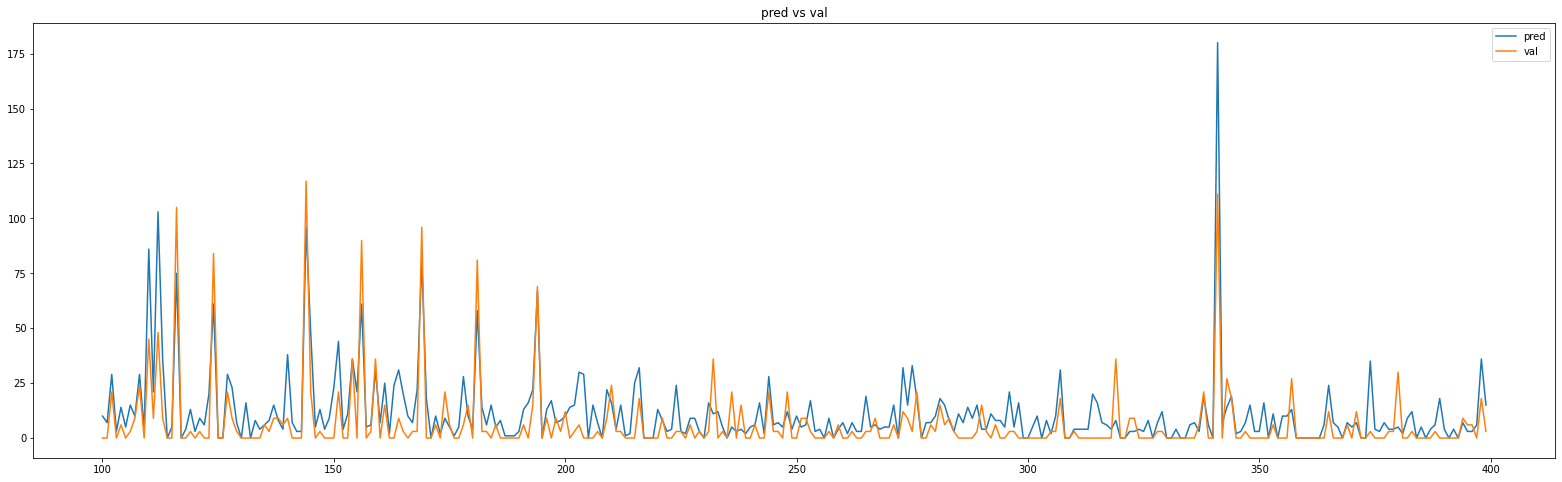

In [ ]:
df_y_test      = pd.DataFrame(data=y_test)
df_y_pred_test = pd.DataFrame(data=y_pred_test)

print(f'SCALED Y: {SCALE_Y}')
if SCALE_Y:
  df_y_test      = pd.DataFrame(scalerY.inverse_transform(df_y_test), columns=df_y_test.columns)  
  df_y_pred_test = pd.DataFrame(scalerY.inverse_transform(df_y_pred_test), columns=df_y_pred_test.columns)

df_y_pred_test = pd.DataFrame( np.around(tf.keras.activations.relu(df_y_pred_test).numpy()), columns=df_y_pred_test.columns)

print("Test")
print(f'mse: {tf.reduce_mean(tf.keras.losses.mean_squared_error(df_y_test, df_y_pred_test)):.5f}')
print(f'smape: {SMAPE(df_y_test, df_y_pred_test):.5f}')
print(f'rrmse: {rRMSE(df_y_test, df_y_pred_test):.5f}')

unscale = False
start = 100
amount = 300

fig = plt.figure(figsize=(60, 8))

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(df_y_pred_test.iloc[start:start+amount, 0], label='pred')
ax2.plot(df_y_test.iloc[start:start+amount, 0], label='val')
ax2.set_title("pred vs val")

plt.legend()
plt.show()

# 6. Submission

In [ ]:
df_estimate_final.sort_values(['fecha', 'id'], inplace=True, ignore_index=True)
df_estimate_scaled.sort_values(['fecha', 'id'], inplace=True, ignore_index=True)

# Predictions
df_estimate_pred = df_estimate_scaled[X_train.columns].copy()
df_estimate_pred['unidades_vendidas'] = np.around( tf.keras.activations.relu( model.predict(df_estimate_pred) ) )
df_estimate_pred['fecha'] = df_estimate_final['fecha'].copy()
df_estimate_pred['id']    = df_estimate_final['id'].copy()

# Extract required columns for submission
df_estimate_send = df_estimate_pred[['fecha', 'id', 'unidades_vendidas']].copy()

df_estimate_send['fecha'] = df_estimate_send['fecha'].dt.strftime('%d/%m/%Y')
df_estimate_send = df_estimate_send.astype({ "fecha": str , "id": int ,"unidades_vendidas": int})
df_estimate_send.rename(columns={"fecha": "FECHA", "id": "ID", "unidades_vendidas": "UNIDADES"}, inplace=True)

# Submission
df_estimate_send.to_csv(path_or_buf=join(DIR_DATASET_BASE, f'Estimaciones_tmp.txt'),encoding="utf-8", sep='|', index=False)

df_estimate_send = pd.read_csv(filepath_or_buffer=join(DIR_DATASET_BASE, f'Estimaciones_tmp.txt'), sep='|')

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done  95 out of  95 | elapsed:    2.5s finished


# 7. Display estimates

In [ ]:
id = df_estimate_final.loc[1000,'id']

df_estimate_con_ventas = df_estimate_final.copy()
df_estimate_con_ventas['unidades_vendidas'] = df_estimate_pred['unidades_vendidas']

df_train_id = df_model_final[df_model_final['id'] == id]
df_estim_id = df_estimate_con_ventas[df_estimate_con_ventas['id'] == id]

display(df_train_id.tail())
display(df_estim_id.head())

,fecha,id,visitas,categoria_uno,categoria_dos,estado,precio,dia_atipico,campaña,antiguedad,unidades_vendidas,day,month,year,Year sin,Week sin,Year cos,Week cos,timestamp,fiestaSP,fiestaPT
1750193,2016-09-26,239010.0,20.0,65.0,197.0,3.0,16.05,0.0,0.0,1509.0,0.0,26.0,9.0,2016.0,-0.996174,-4.338837e-01,-0.087397,-0.900969,1.474848e+09,0,0
1754361,2016-09-27,239010.0,30.0,65.0,197.0,3.0,16.05,0.0,0.0,1510.0,3.0,27.0,9.0,2016.0,-0.997530,-9.749279e-01,-0.070248,-0.222521,1.474934e+09,0,0
1758529,2016-09-28,239010.0,5.0,65.0,197.0,3.0,16.05,0.0,0.0,1511.0,0.0,28.0,9.0,2016.0,-0.998590,-7.818315e-01,-0.053078,0.623490,1.475021e+09,0,0
1762697,2016-09-29,239010.0,25.0,65.0,197.0,3.0,16.05,0.0,0.0,1512.0,3.0,29.0,9.0,2016.0,-0.999356,-5.192230e-13,-0.035892,1.000000,1.475107e+09,0,0
1766865,2016-09-30,239010.0,50.0,65.0,197.0,3.0,16.05,0.0,0.0,1513.0,0.0,30.0,9.0,2016.0,-0.999825,7.818315e-01,-0.018696,0.623490,1.475194e+09,0,0


,fecha,id,visitas,categoria_uno,categoria_dos,estado,precio,dia_atipico,campaña,antiguedad,day,month,year,Year sin,Week sin,Year cos,Week cos,timestamp,fiestaSP,fiestaPT,unidades_vendidas
1000,2016-10-01,239010.0,35.0,65.0,197.0,3.0,16.05,0.0,0.0,1514.0,1.0,10.0,2016.0,-0.999999,0.974928,-0.001494,-0.222521,1.475280e+09,0,0,4.0
3423,2016-10-02,239010.0,25.0,65.0,197.0,3.0,16.05,0.0,0.0,1515.0,2.0,10.0,2016.0,-0.999877,0.433884,0.015708,-0.900969,1.475366e+09,0,0,4.0
5839,2016-10-03,239010.0,85.0,65.0,197.0,3.0,16.05,0.0,0.0,1516.0,3.0,10.0,2016.0,-0.999458,-0.433884,0.032905,-0.900969,1.475453e+09,0,0,8.0
8243,2016-10-04,239010.0,45.0,65.0,197.0,3.0,16.05,0.0,0.0,1517.0,4.0,10.0,2016.0,-0.998745,-0.974928,0.050093,-0.222521,1.475539e+09,0,0,3.0
10634,2016-10-05,239010.0,50.0,65.0,197.0,3.0,16.05,0.0,0.0,1518.0,5.0,10.0,2016.0,-0.997735,-0.781831,0.067266,0.623490,1.475626e+09,0,1,3.0


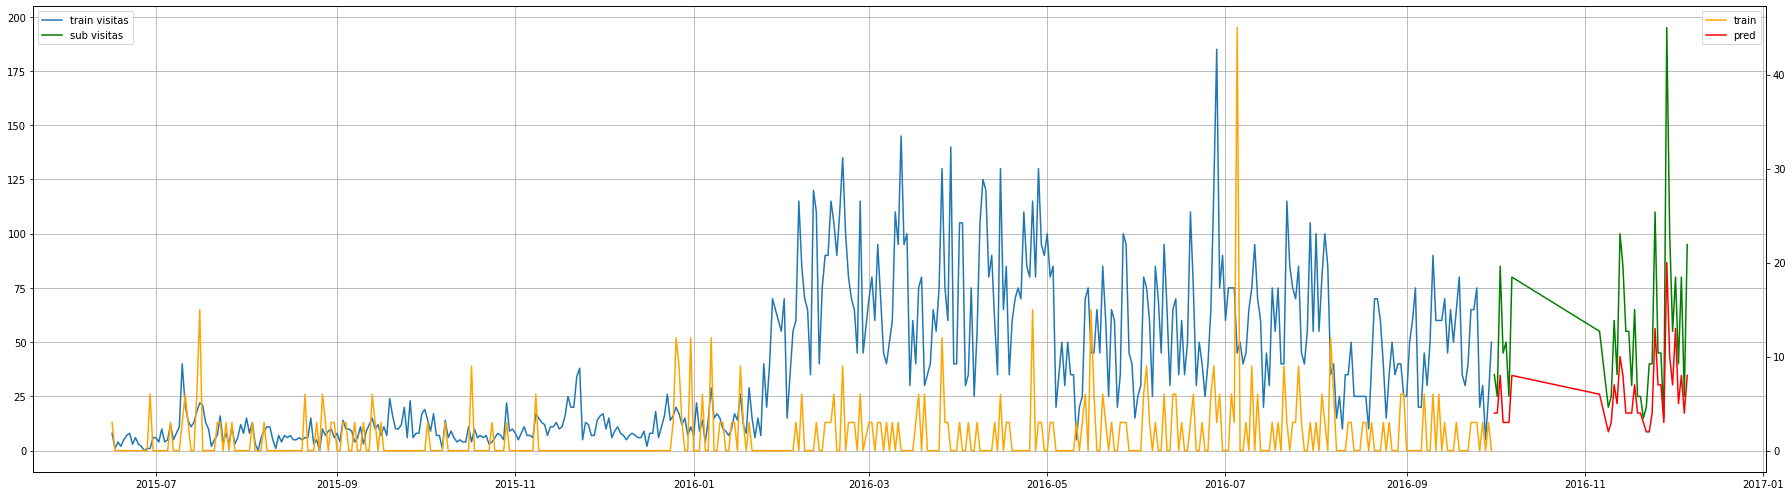

In [ ]:
fig, axs = plt.subplots(1, 1, tight_layout=True, figsize=(25, 7), sharex=True)
axs.plot(df_train_id['fecha'], df_train_id['visitas'], label='train visitas')
axs.plot(df_estim_id['fecha'], df_estim_id['visitas'], label='sub visitas', color='green')
# axs[0].set_yscale('symlog')

ax2=axs.twinx()
ax2.plot(df_train_id['fecha'], df_train_id['unidades_vendidas'], label='train', color='orange')
ax2.plot(df_estim_id['fecha'], df_estim_id['unidades_vendidas'], label='pred', color='red')

axs.legend(loc='upper left')
ax2.legend()
axs.grid(which='both')
fig.show()
# axs[1].legend()
# axs[1].grid(which='both')

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x = df_train_id['fecha'],y= df_train_id['visitas'], name="train visitas", marker_color='blue'), secondary_y=False,
)
fig.add_trace(
    go.Scatter(x = df_estim_id['fecha'],y= df_estim_id['visitas'], name="sub visitas", marker_color='green'),secondary_y=False,
)
fig.add_trace(
    go.Scatter(x = df_train_id['fecha'],y= df_train_id['unidades_vendidas'], name="train unidades", marker_color='orange'),secondary_y=True,
)
fig.add_trace(
    go.Scatter(x = df_estim_id['fecha'], y= df_estim_id['unidades_vendidas'], name="sub unidades", marker_color='red'),secondary_y=True,
)
fig.update_layout(
    autosize=False,
    width=2000,
    height=500,
    margin=dict( l=0, r=0, b=0, t=0, pad=1),
    legend=dict(x=0, y=1, traceorder='normal', font=dict(size=12,),)
)
fig.show()